In [2]:
#Imports
import sys
sys.path.append('../../python/')
import NGC5533_functions as nf

import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import lmfit as lm
import dataPython as dp

In [5]:
data = dp.getXYdata_wXYerr('../data/100kpc_data.txt')
r_dat = np.asarray(data['xx'])
v_dat = np.asarray(data['yy'])
v_err0 = np.asarray(data['ex'])
v_err1 = np.asarray(data['ey'])

#change r_dat so it's strictly increasing
r_dat, v_dat, v_err0, v_err1 = (list(a) for a in zip(*sorted(zip(r_dat, v_dat, v_err0, v_err1))))
#converting v_err1 to an array
v_err1 = np.asarray(v_err1)
weighdata = 1/v_err1

In [13]:
#keeping others but holding them constant
def f(r,n,re,):
     return np.sqrt(nf.bh_v(r_dat,load=True,path='../')**2 
                    + nf.h_v(r,load=True,path='../')**2 
                    + nf.b_v(r,n,re,load=True,path='../')**2 
                    + nf.d_v(r,load=True,path='../')**2)
def b(r,n,re):
    return nf.b_v(r,n,re,load=True,path='../')

In [14]:
#Fit, Keeping rest constant

#Setup
l_mod = lm.Model(f)
l_params = l_mod.make_params()
#Bulge
l_params.add('n', value=nf.n_c, min=0) 
l_params.add('re', value=nf.re_c, min=0) 

#Do fit
l_fit = l_mod.fit(v_dat,l_params,r=r_dat,weights=weighdata)

In [ ]:
#Fit, B Only

#Setup
l_mod = lm.Model(b)
l_params = l_mod.make_params()
#Bulge
l_params.add('n', value=nf.n_c, min=0) 
l_params.add('re', value=nf.re_c, min=0) 

#Do fit
l_fit = l_mod.fit(v_dat,l_params,r=r_dat,weights=weighdata)

../../python/NGC5533_functions.py:182: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return si.quad(h, 0, r, args=(r,n,re))[0]
../../python/NGC5533_functions.py:182: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return si.quad(h, 0, r, args=(r,n,re))[0]


In [ ]:
#Fit, B Only

#Define Stuff
b_dict = b_fit.best_values
#Bulge
l_n = l_dict['n']
l_re = l_dict['re']

l_curve = f(r_dat,l_n,l_re)

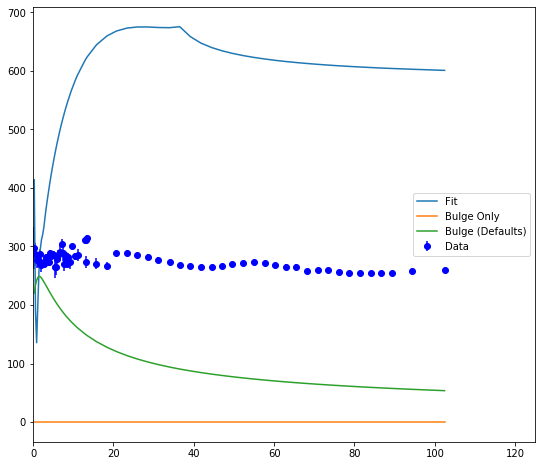

In [11]:
fig = plt.figure(figsize=(9.0,8.0))

plt.xlim(0,125)

plt.errorbar(r_dat,v_dat,yerr=v_err1,fmt='bo',label='Data')
plt.plot(r_dat,l_curve,label='Fit')
plt.plot(r_dat,nf.b_v(r_dat,l_n,l_re),label='Bulge Only')
plt.plot(r_dat,nf.b_v(r_dat,load=True),label='Bulge (Defaults)')

plt.legend()
plt.savefig('Fitting_with_library.png')
plt.show()

l_fit

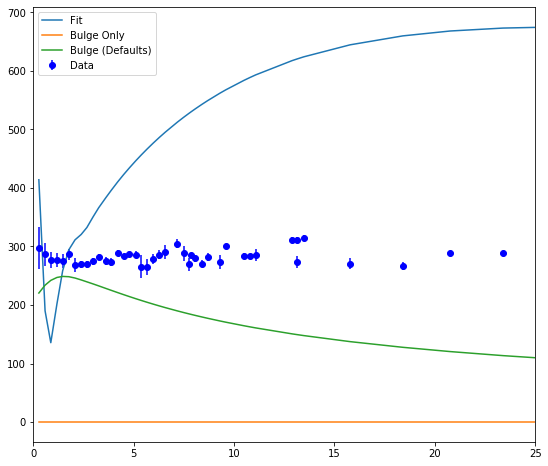

In [10]:
fig = plt.figure(figsize=(9.0,8.0))

plt.xlim(0,25)

plt.errorbar(r_dat,v_dat,yerr=v_err1,fmt='bo',label='Data')
plt.plot(r_dat,l_curve,label='Fit')
plt.plot(r_dat,nf.b_v(r_dat,l_n,l_re),label='Bulge Only')
plt.plot(r_dat,nf.b_v(r_dat,load=True),label='Bulge (Defaults)')

plt.legend()
plt.savefig('Fitting_with_library.png')
plt.show()

l_fit